![Forecasting Demo 1: Baselines, Prophet, and NeuralProphet](https://raw.githubusercontent.com/VectorInstitute/forecasting-bootcamp/media-assets-do-not-merge/forecasting-demo-1.png?token=GHSAT0AAAAAABQMCWQFQHUMDN4MVB2LEQDUYQ7WXUQ)

This notebook is the first of a series that introduces the application of popular, recently developed time series forecasting methods. In particular, we emphasize the use of consistent evaluation metrics and analysis across all models and model configurations. 

Use these notebooks as tools to explore the application of various forecasting methods to multivariate time series datasets, and to inspire an experimental approach for comparing multiple models and model configurations.

This notebook explores the application of **Prophet** and **NeuralProphet** to exchange rate forecasting, as well as two baseline methods using **sktime**.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    !pip install sktime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet
from neuralprophet import NeuralProphet

# Data Loading

In [2]:
!pwd

/ssd003/home/sherryxie/forecasting-bootcamp/demos


### Load bitcoin data file

In [3]:
data_filename = "/ssd003/home/sherryxie/forecasting-bootcamp/datasets/BTC-USD.csv"
data_df = pd.read_csv(data_filename, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-11-18,16687.912109,16947.058594,16564.611328,16697.777344,16697.777344,26862218609
2022-11-19,16696.220703,16797.876953,16570.410156,16711.546875,16711.546875,16106223492
2022-11-20,16712.919922,16746.779297,16248.692383,16291.832031,16291.832031,21313378652


In [4]:
data_df = data_df.assign(day_of_week = data_df.index.dayofweek)\
        .assign(month = data_df.index.month)\
        .assign(week_of_year = data_df.index.week)


data_df.head()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1749/1404987358.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  .assign(week_of_year = data_df.index.week)



,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,week_of_year
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2,9,38
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,3,9,38
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,4,9,38
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,5,9,38
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,6,9,38


In [5]:
# data_df['day_of_week'] = data_df['day_of_week'].astype(np.float64)
# data_df['month'] = data_df['month'].astype(np.float64)
# data_df['week_of_year'] = data_df['week_of_year'].astype(np.float64)

In [6]:
data_df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
day_of_week       int64
month             int64
week_of_year      int64
dtype: object

In [7]:
data_df = data_df.reset_index().rename({'index':'Date'}, axis=1)
data_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,week_of_year
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2,9,38
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,3,9,38
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,4,9,38
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,5,9,38
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,6,9,38


In [8]:
data_df['day_of_week'] = data_df['day_of_week'].astype(np.float64)
data_df['month'] = data_df['month'].astype(np.float64)
data_df['week_of_year'] = data_df['week_of_year'].astype(np.float64)
data_df['Volume'] = data_df['Volume'].astype(np.float64)

### Split data according to use case

For simplicity, this notebook uses a conventional training and testing split over the dataset. Other notebooks will give examples of rolling cross validation using multiple validation periods given by a set of cutoff dates. 

The purpose of this notebook is to explore a simpler problem formulation using multiple models. The experiments and analysis can be easily adapted for rolling cross validation.

In [9]:
lag_time = 60
lead_time = 7

train_size = 0.8

train_df = data_df.iloc[:int(len(data_df)*train_size)]
test_df = data_df.iloc[int(len(data_df)*train_size):]

To ensure that we have enough data for testing, we need to withhold at least `lag_time + lead_time` observations from the dataset. Assuming we want to test a fitted model on all available examples in the test set, the number of testing examples can be computed as follows.

In [10]:
n_test_cases = len(test_df) - lag_time - lead_time + 1
print(f"   Timesteps in test_df: {len(test_df)}")
print(f"Number of test examples: {n_test_cases}")

   Timesteps in test_df: 598
Number of test examples: 532


### Iterating over test examples

To help with iterating over valid pairs of input and target data, we define a PyTorch-like dataset class. In this notebook, we'll use this primarily for iterating over test examples, since both Prophet and NeuralProphet impose their own, special formats for passing in training data.

In [11]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time + 1
        assert self.n_examples > 0, "Dataset must contain at least one example."
        assert "Date" in data_df.columns or "ds" in data_df.columns  , "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'Date' in data_df.columns:
            self.dates = data_df.Date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

Next, we instantiate an indexable `test_dataset`. 

In [12]:
test_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'day_of_week', 'month', 'week_of_year'],
      dtype='object')

In [13]:
feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'day_of_week', 'week_of_year', 'month']
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

# Evaluation Metrics

In order to objectively compare the performance of this and other models on out-of-sample forecasting performance, we will need to collect output in a consistent format and apply a suite of standard evaluation metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

See the article [Time Series Forecast Error Metrics You Should Know](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27) for an overview of these and other popular forecasting error metrics. 


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

In [15]:
def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

# Baseline Forecasts

Let's begin our experiments by producing forecasts using naïve estimators. A common baseline is *persistence forecasting*, where the forecast is simply an extension of the last known observation of the time series. A second baseline is the *mean window forecast*, where we take the mean over a window of observations and use this value for forecasts. The following code produces and collects the baseline forecasts into lists. 

In [16]:
x, y, x_d, y_d = test_dataset[0]
print(x)
print(y)

              Open          High           Low         Close     Adj Close  \
2391  57604.839844  58913.746094  57168.675781  58758.554688  58758.554688   
2392  58760.875000  59891.296875  57694.824219  59057.878906  59057.878906   
2393  59171.933594  59479.578125  57646.808594  58192.359375  58192.359375   
2394  58186.507813  58731.144531  55604.023438  56048.937500  56048.937500   
2395  56099.914063  58338.738281  55879.085938  58323.953125  58323.953125   
2396  58326.562500  58937.046875  57807.863281  58245.003906  58245.003906   
2397  58253.777344  61276.664063  58038.707031  59793.234375  59793.234375   
2398  59846.230469  60790.554688  59289.796875  60204.964844  60204.964844   
2399  60175.945313  61253.035156  59589.875000  59893.453125  59893.453125   
2400  59890.019531  63742.285156  59869.957031  63503.457031  63503.457031   
2401  63523.753906  64863.097656  61554.796875  63109.695313  63109.695313   
2402  63075.195313  63821.671875  62208.964844  63314.011719  63

In [17]:
baseline_model_persistence = NaiveForecaster(strategy='last')
baseline_model_mean = NaiveForecaster(strategy='mean',window_length=lag_time)

forecasts_persistence = []
forecasts_mean = []

for i in range(len(test_dataset)):
    x, y, x_d, y_d = test_dataset[i]
    
    persistence_fc = baseline_model_persistence.fit_predict(x['Adj Close'], fh=list(range(1, lead_time+1)))
    persistence_fc = pd.Series(persistence_fc.values, index=y_d)
    forecasts_persistence.append(persistence_fc)

    mean_fc = baseline_model_mean.fit_predict(x['Adj Close'], fh=list(range(lead_time)))
    mean_fc = pd.Series(mean_fc.values, index=y_d)
    forecasts_mean.append(mean_fc)

    print(i, end='\r')

### Compute error metrics over the baseline forecasts

In this notebook, we want to compare the performance of experimental models (Prophet, NeuralProphet) compared to baselines (persistence and mean window extension). The following code applies each of the four evaluation metrics for every example in the test set. 

In [18]:
def compute_baseline_error_metrics(forecasts, test_dataset):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        x, y, x_d, y_d = test_dataset[i]
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=y['Adj Close'], y_pred=fc))

    return errors, forecasts

persistence_errors, _ = compute_baseline_error_metrics(forecasts_persistence, test_dataset)
mean_errors, _ = compute_baseline_error_metrics(forecasts_mean, test_dataset)

The following code uses the function `compute_error_statistics` to reduce the mean evaluation metrics over the entire test set to three statistics (mean, standard deviation, and max).

In [19]:
persistence_stats = compute_error_statistics(persistence_errors, 'persistence')
persistence_stats['mean']

mse     6.968493e+06
rmse    2.136756e+03
mae     1.860883e+03
mape    5.149517e-02
Name: persistence_mean_metrics, dtype: float64

In [20]:
mean_window_stats = compute_error_statistics(mean_errors, 'mean_window')
mean_window_stats['mean']

mse     4.933859e+07
rmse    5.811160e+03
mae     5.652429e+03
mape    1.586152e-01
Name: mean_window_mean_metrics, dtype: float64

We now collect the mean evaluation statistics for each metric into a DataFrame so that we can later compare these to experimental models.

In [21]:
results_df = pd.DataFrame(persistence_stats['mean']).T
results_df = results_df.append(mean_window_stats['mean'])
results_df

,mse,rmse,mae,mape
persistence_mean_metrics,6.968493e+06,2136.756304,1860.883106,0.051495
mean_window_mean_metrics,4.933859e+07,5811.159776,5652.428705,0.158615


### Visualizing forecasts over the test set

For each example in the test set, we have produced a forecast between `1` and `lead_time` days into the future. As we will see later, this is difficult to visualize over the whole test set. Instead, we can visualize the value of each forecast at a single time step into the future. The code below visualizes the baseline forecasts at the maximum lead time. As we can see, the persistence forecast is exactly the ground truth shifted `lead_time` days into the future. In the context of exchange rate forecasting, this baseline may be difficult to beat.

#### Persistence Forecasts At Max Lead Time

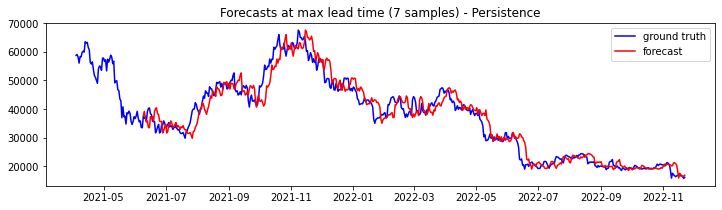

In [22]:
max_fcs = [{'Date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts_persistence]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.Date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
plt.legend(loc='upper right')

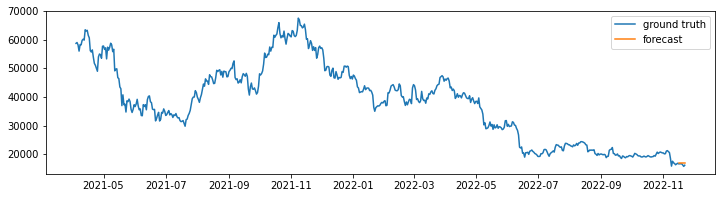

In [23]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts_persistence[-1], label='forecast')
plt.legend()

#### Mean Window Forecasts At Max Lead Time

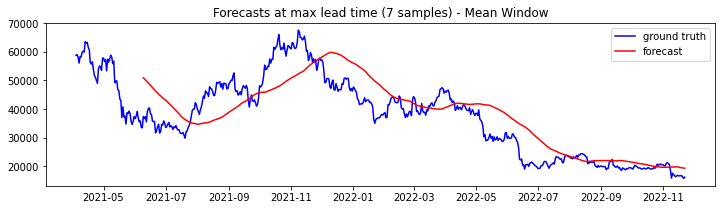

In [24]:
max_fcs = [{'Date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts_mean]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.Date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Mean Window")
plt.legend(loc='upper right')

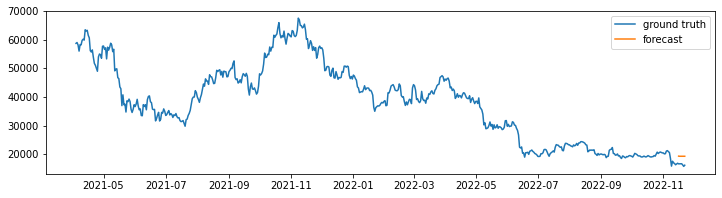

In [25]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts_mean[-1], label='forecast')
plt.legend()

# Prophet

Univariate forecasting that supports additional *future* regressors. Prophet does not support the inclusion of *lagged regressors*, i.e. it does not support the use of historical values of multiple series to predict a single target series. We include it as a baseline because it is popular, lightweight, interpretable, and performs very well in some domains. 

Prophet is based on a Generalized Additive Model (GAM):

$ y(t) = g(t) + s(t) + h(t) + \epsilon_t$

where $y(t)$ is the target series, $g(t)$ is the trend function, $s(t)$ is the seasonality or periodic function, $h(t)$ is a function reflecting holidays or other irregular events, and $\epsilon_t$ is an error term that is assumed to be normally distributed.

Despite being formulated as an additive model, multiplicative interaction between seasonality and trend components is supported (using a log transform). In the implementation, this is easily configurable using a constructor parameter. See the [documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for more details.

#### Data Preparation

Prophet, like most forecasting packages, imposes its own, specific format for input data. It expects inputs in the form of a Pandas DataFrame with two columns, `ds` and `y`, which correspond to Pandas-formatted timestamps and the target time series, respectively.

In this example, we create a Prophet DataFrame by selecting the columns `date` and `USD_CLOSE` from the Bank of Canada exchange rate dataset. We then rename those columns to `ds` and `y`, respectively. 

Note that the `ds` column is already correctly formatted using the Pandas datetime format, since we converted it immediately after loading the data. When reading CSVs, always be sure to check that datestamps are properly formatted.

In [26]:
prophet_model_df = train_df[['Date', 'Adj Close']]
prophet_model_df = train_df.rename({'Date':'ds', 'Adj Close':'y'}, axis=1)
prophet_model_df = prophet_model_df[['ds', 'y']]
prophet_model_df

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
2386,2021-03-30,58917.691406
2387,2021-03-31,58918.832031
2388,2021-04-01,59095.808594
2389,2021-04-02,59384.312500


### Model Initialization and Fitting

For our baseline model, we fit Prophet using its default configuration.

In [27]:
model = Prophet()
model = model.fit(prophet_model_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -212.086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4839.68    0.00785587       471.411      0.6073      0.6073      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       4923.98   0.000649454       462.248   1.084e-06       0.001      247  LS failed, Hessian reset 
     199       4933.99    0.00330786       190.994           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4948.95    0.00134271       124.129      0.9669      0.9669      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4957.5    0.00218785       160.531      0.5036           1      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     486        4959.1     0.0018135    

### Produce Forecasts

To produce a forecast using a fitted Prophet model, we need to pass it a dataframe with the desired timestamps in a column named `ds`. In the example below, we use the fitted model object to produce a dataframe `future` with dates that extend `len(test_df)` days beyond the training dates. Passing `future` to the fitted model's `predict` function will return a dataframe populated with a detailed forecast, including model component values and confidence ranges.

Notice here that we are asking Prophet to produce a single forecast for the entire test period. We are doing this because Prophet does not support inference using fixed-sized inputs in the same way that every other technique considered in our bootcamp does. 

In [28]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [29]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2984,2022-11-18,75398.600587,58293.172162,90433.018021,60119.835693,90488.531587,-627.841107,-627.841107,-627.841107,29.919669,29.919669,29.919669,-657.760777,-657.760777,-657.760777,0.0,0.0,0.0,74770.759479
2985,2022-11-19,75466.921785,57866.097759,91247.211635,60138.104242,90584.829260,-569.265253,-569.265253,-569.265253,53.108695,53.108695,53.108695,-622.373948,-622.373948,-622.373948,0.0,0.0,0.0,74897.656531
2986,2022-11-20,75535.242983,58926.866992,90779.417000,60156.372790,90682.217908,-621.802222,-621.802222,-621.802222,-40.421753,-40.421753,-40.421753,-581.380469,-581.380469,-581.380469,0.0,0.0,0.0,74913.440761
2987,2022-11-21,75603.564181,58485.777648,91447.940885,60174.641338,90784.916722,-555.257145,-555.257145,-555.257145,-19.911108,-19.911108,-19.911108,-535.346037,-535.346037,-535.346037,0.0,0.0,0.0,75048.307036
2988,2022-11-22,75671.885379,58715.562219,91642.672108,60192.909887,90888.905431,-514.288426,-514.288426,-514.288426,-29.311991,-29.311991,-29.311991,-484.976435,-484.976435,-484.976435,0.0,0.0,0.0,75157.596953


In [30]:
test_df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,week_of_year
2984,2022-11-18,16687.912109,16947.058594,16564.611328,16697.777344,16697.777344,2.686222e+10,4.0,11.0,46.0
2985,2022-11-19,16696.220703,16797.876953,16570.410156,16711.546875,16711.546875,1.610622e+10,5.0,11.0,46.0
2986,2022-11-20,16712.919922,16746.779297,16248.692383,16291.832031,16291.832031,2.131338e+10,6.0,11.0,46.0
2987,2022-11-21,16291.223633,16291.223633,15599.046875,15787.284180,15787.284180,3.742949e+10,0.0,11.0,47.0
2988,2022-11-22,15778.548828,16202.363281,15656.606445,16202.363281,16202.363281,3.589274e+10,1.0,11.0,47.0


### Plotting Prophet Forecasts

The following code visualizes the application of the fitted Prophet model to both in-sample (training) and out-of-sample (testing) data. Visualization and evaluation of forecasting models using out-of-sample data is crucial for estimating future performance.

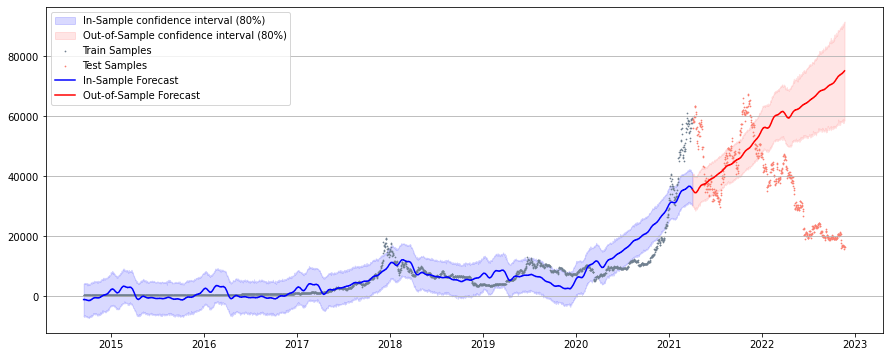

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.fill_between(forecast.ds.iloc[:-len(test_df)], 
    forecast.yhat_lower.iloc[:-len(test_df)], 
    forecast.yhat_upper.iloc[:-len(test_df)],
    color='blue', label='In-Sample confidence interval (80%)', alpha=0.15)

ax.fill_between(forecast.ds.iloc[-len(test_df):], 
    forecast.yhat_lower.iloc[-len(test_df):], 
    forecast.yhat_upper.iloc[-len(test_df):],
    color='red', label='Out-of-Sample confidence interval (80%)', alpha=0.1)

ax.scatter(prophet_model_df.ds, prophet_model_df['y'], color='slategrey', s=3, linewidths=0, label='Train Samples')
ax.scatter(test_df.Date, test_df['Adj Close'], color='salmon', s=3, linewidths=0, label='Test Samples')

ax.plot(forecast.ds.iloc[:-len(test_df)], 
        forecast.yhat.iloc[:-len(test_df)], color='blue', label='In-Sample Forecast')

ax.plot(forecast.ds.iloc[-len(test_df):], forecast.yhat.iloc[-len(test_df):], 
        color='red', label='Out-of-Sample Forecast')

ax.legend(loc='upper left')
ax.grid(axis='y')
plt.show()

### Prophet Forecasts At Max Lead Time

As we did with the baseline methods, let's visualize Prophet's forecasts at maximum lead time. 

In [32]:
# forecast

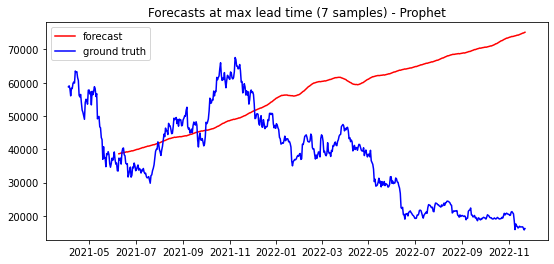

In [33]:
# We can use our ForecastingDataset class to help with formatting Prophet's output.
forecast_eval_dataset = ForecastingDataset(forecast.iloc[-len(test_df):], lag_time, lead_time, ['yhat'])

fig, ax = plt.subplots(figsize=(9,4))

forecasts_at_max_lead = []
dates_at_max_lead = []

for i in range(len(forecast_eval_dataset)):
    x, y, x_d, y_d = forecast_eval_dataset[i]
    x_gt, y_gt, x_gt_d, y_gt_d = test_dataset[i]

    forecasts_at_max_lead.append(y.values[-1])
    dates_at_max_lead.append(y_d.values[-1])

ax.plot(dates_at_max_lead, forecasts_at_max_lead, color='red', label='forecast')
ax.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.legend()
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Prophet")
plt.show()

With the help of the ForecastingDataset class defined earlier, iterate over each forecast and ground truth pair, and compute and collect multiple evaluation metrics as defined in the previous cell.

In [34]:
def compute_error_metrics(ground_truth_dataset, forecast_dataset):
        
    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecast_dataset)):
        x, y, x_d, y_d = forecast_dataset[i]
        x_gt, y_gt, x_gt_d, y_gt_d = ground_truth_dataset[i]
        for metric_name, metric_fn in metrics.items(): 
            errors[metric_name].append(metric_fn(y_true=y_gt['Adj Close'], y_pred=y))
    
    return errors

error_metrics = compute_error_metrics(test_dataset, forecast_eval_dataset)

In [35]:
prophet_stats = compute_error_statistics(error_metrics, 'prophet')
prophet_stats['mean']

mse     8.877418e+08
rmse    2.364333e+04
mae     2.353462e+04
mape    9.514574e-01
Name: prophet_mean_metrics, dtype: float64

Let's now collect the mean evaluation metrics into a new DataFrame that we will use for comparative evalution against other models' forecasts.

Please note that the comparison is not completely fair - Prophet has to predict 672 steps into the future at once, whereas our baselines only have to predict the next 60 days.

In [36]:
results_df = results_df.append(prophet_stats['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,6.968493e+06,2136.756304,1860.883106,0.051495
mean_window_mean_metrics,4.933859e+07,5811.159776,5652.428705,0.158615
prophet_mean_metrics,8.877418e+08,23643.331156,23534.620267,0.951457


# NeuralProphet

Let's proceed to explore the [NeuralProphet](https://neuralprophet.com/html/index.html) model. Please review the following resources to learn more:

- [Paper](https://arxiv.org/abs/2111.15397)
- [Documentation](https://neuralprophet.com/html/contents.html)
- [GitHub](https://github.com/ourownstory/neural_prophet)

In the words of its developers, NeuralProphet is "*based on neural networks, inspired by Facebook Prophet and AR-Net, built on PyTorch*". A very important differentiating feature is that NeuralProphet conveniently supports *lagged regressors*. In the context of this running example, NeuralProphet supports the use of multiple other currencies' time series. With this expanded flexibility, however, the model is more complex, with a greater number of design choices and hyperparameters to consider. 

The official [documentation on lagged regressors (lagged covariates)](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html) gives several examples for configuring NeuralProphet models to use lagged regressors, but commentary and suggestions on best practices are largely absent. 

In the following code, we will consider a small number of NeuralProphet model configurations applied to the same forecasting task from above. Importantly, we retain the same train/test (in-sample/out-of-sample) split, and we will apply the same evaluation metrics to NeuralProphet's forecasts. 

### Data Formatting

NeuralProphet's data format is very similar to Prophet's. We prepare new DataFrames for training and evaluation.

In [37]:
np_train_df = train_df.reset_index().rename({'Date':'ds', 'Adj Close':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'Date':'ds','Adj Close':'y'}, axis=1).drop('index', axis=1)

Of course the most important difference between the DataFrames prepared for Prophet and NeuralProphet is that, with NeuralProphet, we have the opportunity to include data about the non-target variables as lagged regressors.

In [38]:
np_train_df.head(5)

,ds,Open,High,Low,Close,y,Volume,day_of_week,month,week_of_year
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,2.0,9.0,38.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,3.0,9.0,38.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,4.0,9.0,38.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,5.0,9.0,38.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,6.0,9.0,38.0


## Baseline/Default Model

A baseline NeuralProphet model with lagged regressors using default initialization parameters, except:

- `n_lags=lag_time`, specifying that the autoregressive component of the model should use the past `lag_time` daily observations as inputs
- `n_forecasts=lead_time`, specifying that our use case is to predict the target signal `lead_time` days into the future

NeuralProphet also allows you to specify a `validation_df` in `fit()`, on which the model will be evaluated every epoch. We are not using this feature here.

In [39]:
#!pip install neuralprophet --upgrade

In [40]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('Adj Close', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 145
INFO:NP.config:Auto-set epochs to 145


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E-02, min: 4.97E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.23E-02, min: 4.97E-02


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.33E-02, min: 4.60E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.33E-02, min: 4.60E-02


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.55E-02, min: 2.89E-02
INFO:NP.utils_torch:lr-range-test results: steep: 1.55E-02, min: 2.89E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.36E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 1.36E-02
Epoch[145/145]: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s, SmoothL1Loss=0.00119, MAE=589, RMSE=911, RegLoss=0]        


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.133997,29745.764383,37466.168054,0.0
1,0.871750,24537.122146,30377.895998,0.0
2,0.757819,22262.654853,27378.308505,0.0
3,0.649639,20028.321619,24579.891797,0.0
4,0.529523,17483.246715,21567.395015,0.0
...,...,...,...,...
140,0.001203,591.959818,917.486675,0.0
141,0.001204,593.347974,915.642813,0.0
142,0.001194,590.700028,914.687320,0.0
143,0.001191,589.871992,911.341073,0.0


After fitting, you can plot the learned model parameters, including the additional 11 lagged regressors (with 90 day lead time).

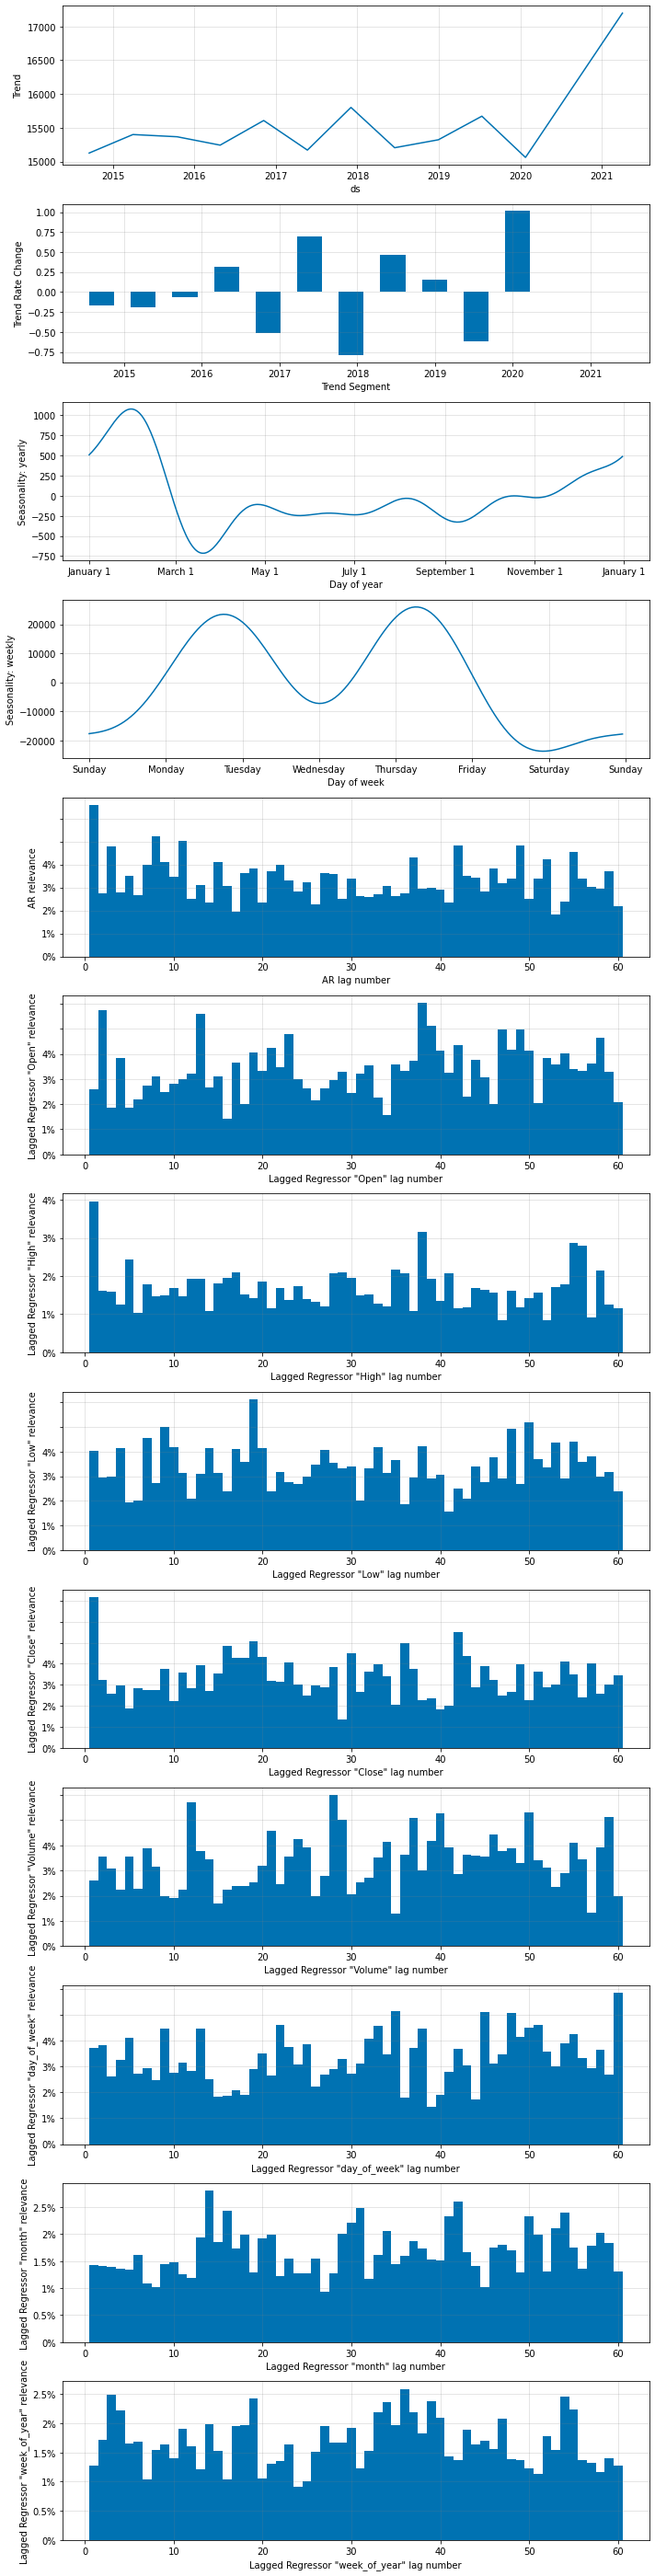

In [41]:
p = np_model.plot_parameters()

NeuralProphet, rather annoyingly, does not collect forecasts into a single yhat variable, but rather into separate `stepX`s for each of the lead times. For example, the following is a single 60-day forecast:

In [42]:
x.dtypes

yhat    float64
dtype: object

In [43]:
x, y, x_d, y_d = test_dataset[0]
x = x.reset_index().rename({'date':'ds', 'Adj Close':'y'}, axis=1).drop('index', axis=1)
x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
y = y.reset_index().rename({'date':'ds', 'Adj Close':'y'}, axis=1).drop('index', axis=1)

np_future_df = np_model.make_future_dataframe(x, periods=len(y))
#np_future_df['Volume'] = np_future_df['Volume'].astype(np.float64)
np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
np_forecast

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6
0,2021-06-03,40713.773438,36282.972656,39686.351562,39561.328125,43591.023438,35605.316406,38689.320312


To get a more useable data structure, the following function takes a NeuralProphet forecast dataframe and turns it into a time series of its predictions:

In [44]:
def yhat_from_neuralprophet_forecast(np_forecast, y_d):
    return pd.Series(np_forecast.T.iloc[1:].set_index(y_d).iloc[:,0], name='np_yhat').rename_axis('ds')

The forecast from above would now look this:

In [45]:
yhat_from_neuralprophet_forecast(np_forecast, y_d)

ds
2021-06-03    40713.773438
2021-06-04    36282.972656
2021-06-05    39686.351562
2021-06-06    39561.328125
2021-06-07    43591.023438
2021-06-08    35605.316406
2021-06-09    38689.320312
Name: np_yhat, dtype: object

Since NeuralProphet uses a fixed-size input sequence (lagged observations) to produce forecasts, we iterate over the input sequences in the test set and use them as model inputs to produce forecasts. This mode of inference should be more familiar to machine learning practitioners than Prophet's. Note that NeuralProphet requires us to first format input data using the `make_future_dataframe` function before running inference using the `predict` function. We define the following function, which produces forecasts for each of the input/ground-truth-output sequences in the test set.

In [46]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'Date':'ds', 'Adj Close':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'Date':'ds', 'Adj Close':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
        fc_series = yhat_from_neuralprophet_forecast(np_forecast, y_d)
        forecasts.append(fc_series)

    return forecasts

Similarly to what we defined for Prophet, we define the following function for computing and collecting evaluation metrics over all of the forecasts.

In [47]:
test_df

,Date,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,week_of_year
2391,2021-04-04,57604.839844,58913.746094,57168.675781,58758.554688,58758.554688,5.074966e+10,6.0,4.0,13.0
2392,2021-04-05,58760.875000,59891.296875,57694.824219,59057.878906,59057.878906,6.070627e+10,0.0,4.0,14.0
2393,2021-04-06,59171.933594,59479.578125,57646.808594,58192.359375,58192.359375,6.605803e+10,1.0,4.0,14.0
2394,2021-04-07,58186.507813,58731.144531,55604.023438,56048.937500,56048.937500,7.564530e+10,2.0,4.0,14.0
2395,2021-04-08,56099.914063,58338.738281,55879.085938,58323.953125,58323.953125,5.305386e+10,3.0,4.0,14.0
...,...,...,...,...,...,...,...,...,...,...
2984,2022-11-18,16687.912109,16947.058594,16564.611328,16697.777344,16697.777344,2.686222e+10,4.0,11.0,46.0
2985,2022-11-19,16696.220703,16797.876953,16570.410156,16711.546875,16711.546875,1.610622e+10,5.0,11.0,46.0
2986,2022-11-20,16712.919922,16746.779297,16248.692383,16291.832031,16291.832031,2.131338e+10,6.0,11.0,46.0
2987,2022-11-21,16291.223633,16291.223633,15599.046875,15787.284180,15787.284180,3.742949e+10,0.0,11.0,47.0


In [48]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.Date.isin(fc.index)].sort_values('Date')  # Sorting because I am not 100% sure that the 'isin' function always preserves order.
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['Adj Close'], y_pred=fc))

    return errors, forecasts

In [49]:
forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

### Plot all forecasts

We have the option to visualize complete forecasts at every time step, but it does not tell us much about the model's performance.

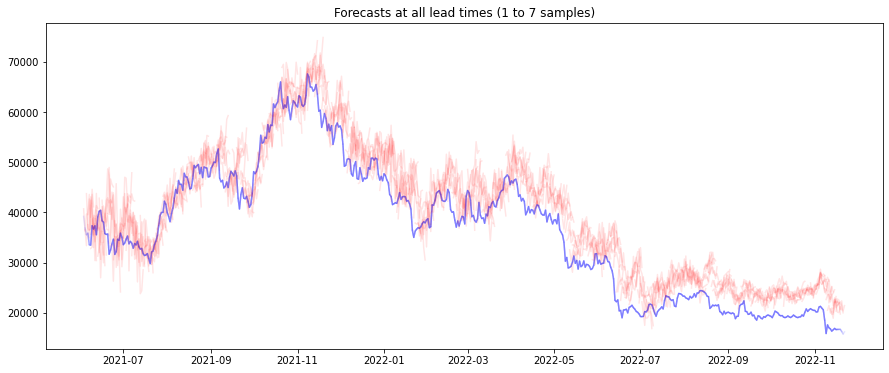

In [50]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.Date.isin(fc.index)]

    ax.plot(fc.index[:], fc[:], alpha=0.1, color='red')
    ax.plot(gt.Date, gt['Adj Close'], alpha=0.1, color='blue')
plt.title(f"Forecasts at all lead times (1 to {lead_time} samples)")
plt.show()

### Plot all forecasts at max lead time

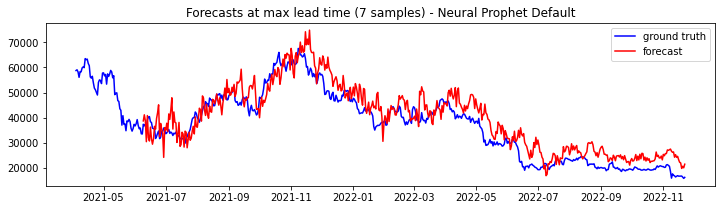

In [51]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet Default")
plt.legend(loc='upper right')

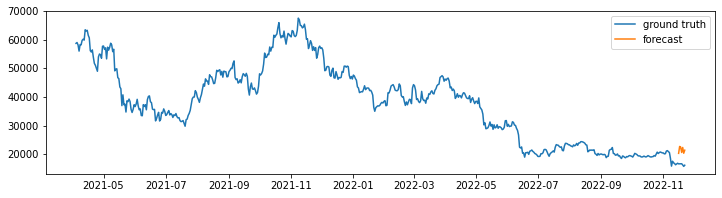

In [52]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [53]:
results_df = results_df.append(compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,6.968493e+06,2136.756304,1860.883106,0.051495
neural_prophet_baseline_mean_metrics,2.636161e+07,4681.659383,4242.120147,0.139498
mean_window_mean_metrics,4.933859e+07,5811.159776,5652.428705,0.158615
prophet_mean_metrics,8.877418e+08,23643.331156,23534.620267,0.951457


## Restricted model

The baseline NeuralProphet model does not perform well on out-of-sample data. We can consider multiple changes to the model's configuration and hyperparameters in pursuit of better performance. Let's consider the following configuration that restricts the model to using only the last observed value of last regressors, as opposed to `n_lags` past observations. While less expressive, this model may be less prone to overfitting.

In [54]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('Adj Close', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}')#, n_lags=1)
    
np_model_last_sample_only.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 145
INFO:NP.config:Auto-set epochs to 145


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.12E-02, min: 3.37E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.12E-02, min: 3.37E-02


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-04, min: 3.65E-02
INFO:NP.utils_torch:lr-range-test results: steep: 5.96E-04, min: 3.65E-02


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.67E-02, min: 5.81E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.67E-02, min: 5.81E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.92E-03
INFO:NP.forecaster:lr-range-test selected learning rate: 7.92E-03
Epoch[145/145]: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s, SmoothL1Loss=0.00139, MAE=644, RMSE=984, RegLoss=0]        
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WAR

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

Once again, we are able to plot the learned parameters of the model. The lagged regressors are now grouped together in a single chart, as only one value of each is used.

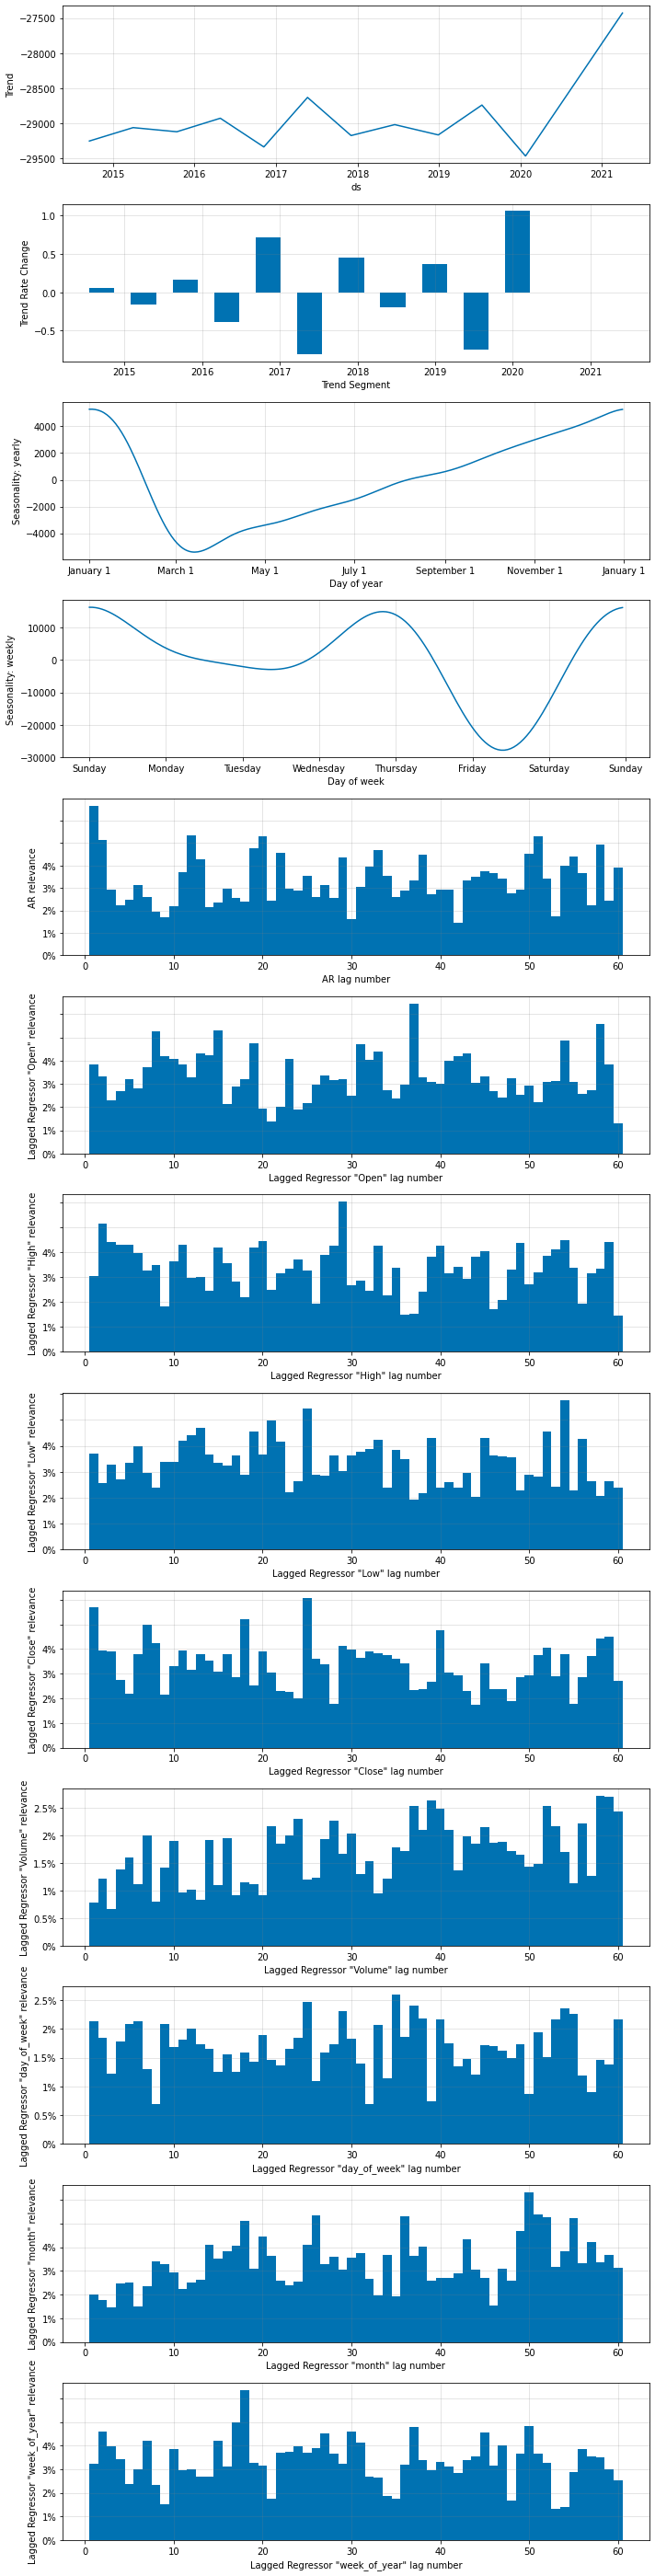

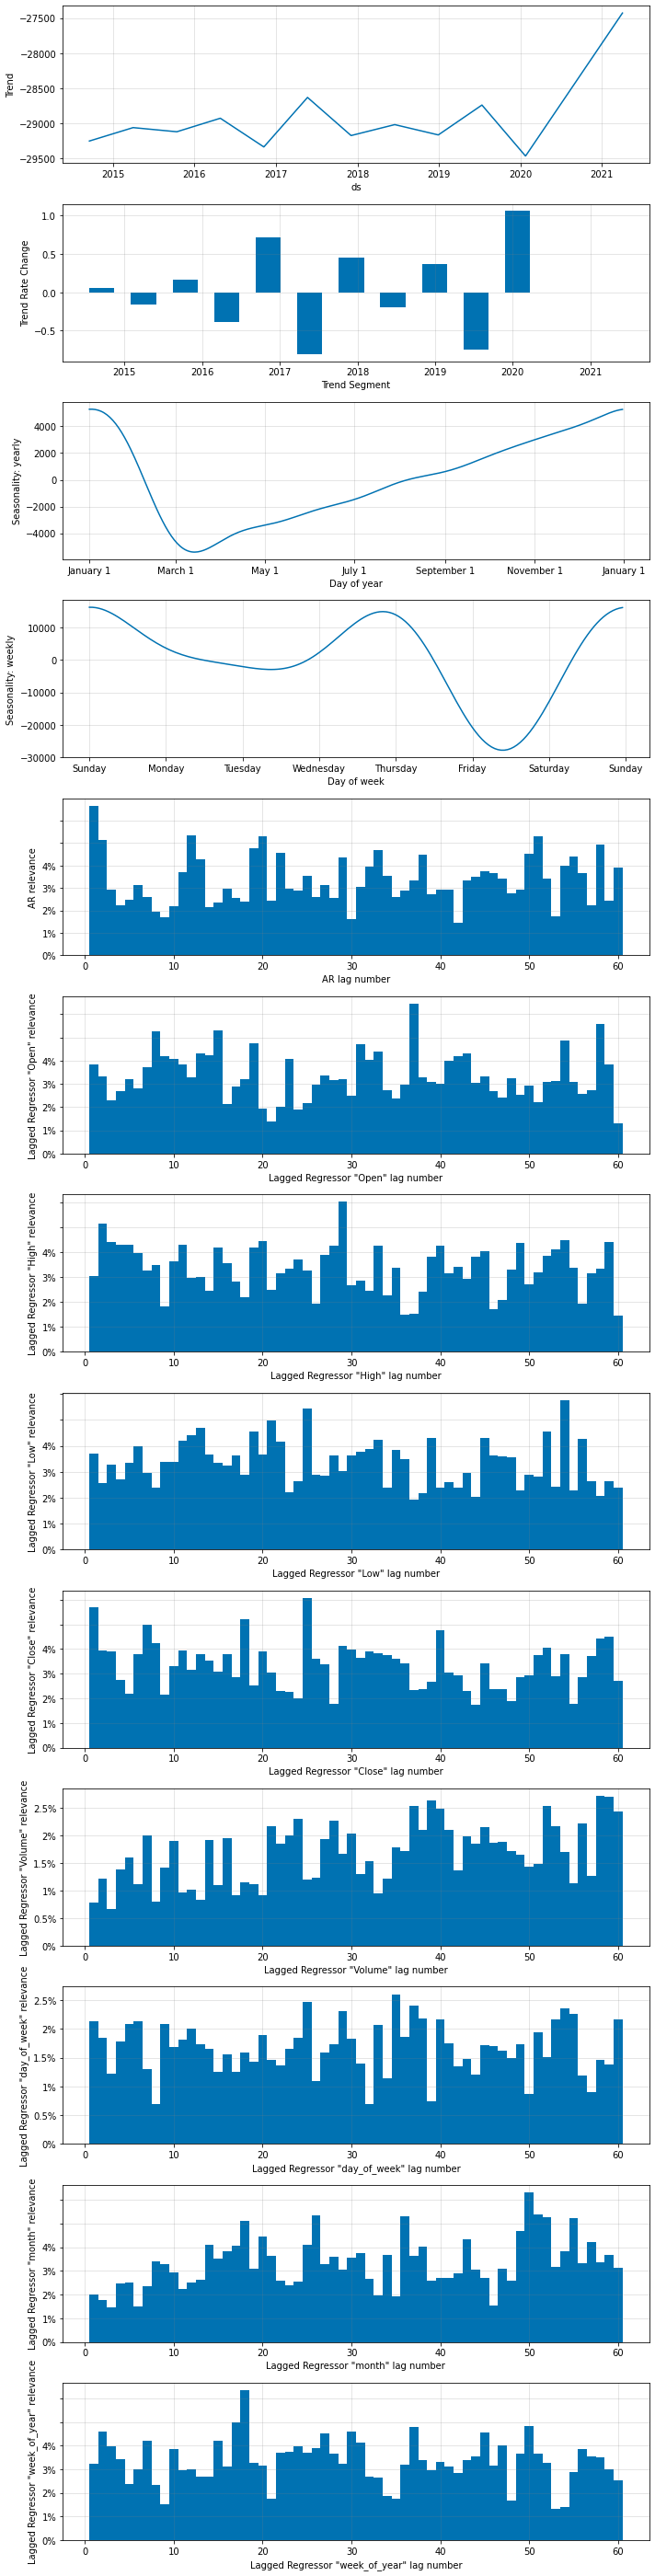

In [55]:
np_model_last_sample_only.plot_parameters()

### Plot forecasts at max lead time

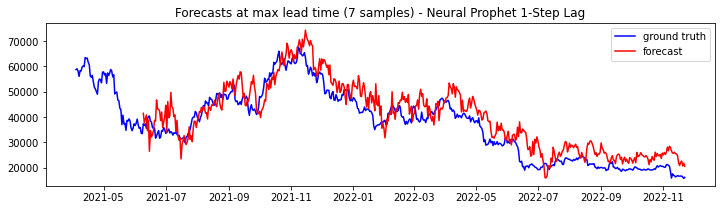

In [56]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet 1-Step Lag")
plt.legend(loc='upper right')

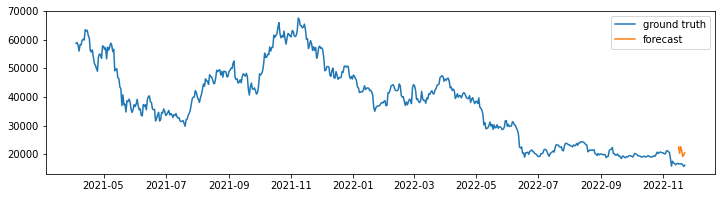

In [57]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [58]:
results_df = results_df.append(compute_error_statistics(np_last_sample_only_error_metrics, 'neural_prophet_last_sample_only')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,6.968493e+06,2136.756304,1860.883106,0.051495
neural_prophet_last_sample_only_mean_metrics,2.415699e+07,4513.934436,4028.250462,0.132026
neural_prophet_baseline_mean_metrics,2.636161e+07,4681.659383,4242.120147,0.139498
mean_window_mean_metrics,4.933859e+07,5811.159776,5652.428705,0.158615
prophet_mean_metrics,8.877418e+08,23643.331156,23534.620267,0.951457


## Model with Sparse Neural Autoregression

In the previous parameter plots, you could see high values for all autoregressive features. You can tell NeuralProphet to try avoiding relying on them too much by restricting how many of them it is able to use. In this case, we set `ar_reg` to 10, which imposes a strong regularization of the AR model towards sparsity in its coefficients. We also reduce the AR depth to 10 days. *Note*: NeuralProphet applies this sparsity factor only to the regular AR coefficients, not the lagged regressor AR coefficients, where higher sparsity would make more sense.

We can also play around with parameters like the number of hidden layers or the learning rate of the AR-Net. Another change applied to this model is the loss function, now MAE instead of the default Huber loss.

This is the previous text of the demo: In the previous parameter plots, you could see high values for all autoregressive features. You can tell NeuralProphet to try avoiding relying on them too much by restricting how many of them it is able to use. In this case, we set `ar_sparsity` to 0.1, meaning the least informative 90% of AR coefficients will not be included in the model. But: NeuralProphet applies this sparsity factor only to the regular AR coefficients, not the lagged regressor AR coefficients, where higher sparsity would make more sense.

In [59]:
np_model_sparse_nar = NeuralProphet(n_lags=10, 
                                    n_forecasts=lead_time,
                                    #ar_reg=10,
                                    ar_sparsity = 0.1,
                                    learning_rate=5e-3,
                                    num_hidden_layers=2,
                                    d_hidden=16,
                                    loss_func='MAE'
                                    )

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('Adj Close', 'ds', 'y')]
for feature in feature_cols:
    #np_model_sparse_nar.add_lagged_regressor(f'{feature}', n_lags=1)
    np_model_sparse_nar.add_lagged_regressor(f'{feature}')
    
np_model_sparse_nar.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_sparse_nar, test_dataset)
np_sparse_ar_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 145
INFO:NP.config:Auto-set epochs to 145
Epoch[145/145]: 100%|██████████| 145/145 [01:40<00:00,  1.44it/s, L1Loss=0.0197, MAE=373, RMSE=826, RegLoss=0.0384]    
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompa

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

In [60]:
#!pip freeze 

In [61]:
#!pip install neuralprophet==0.3.0

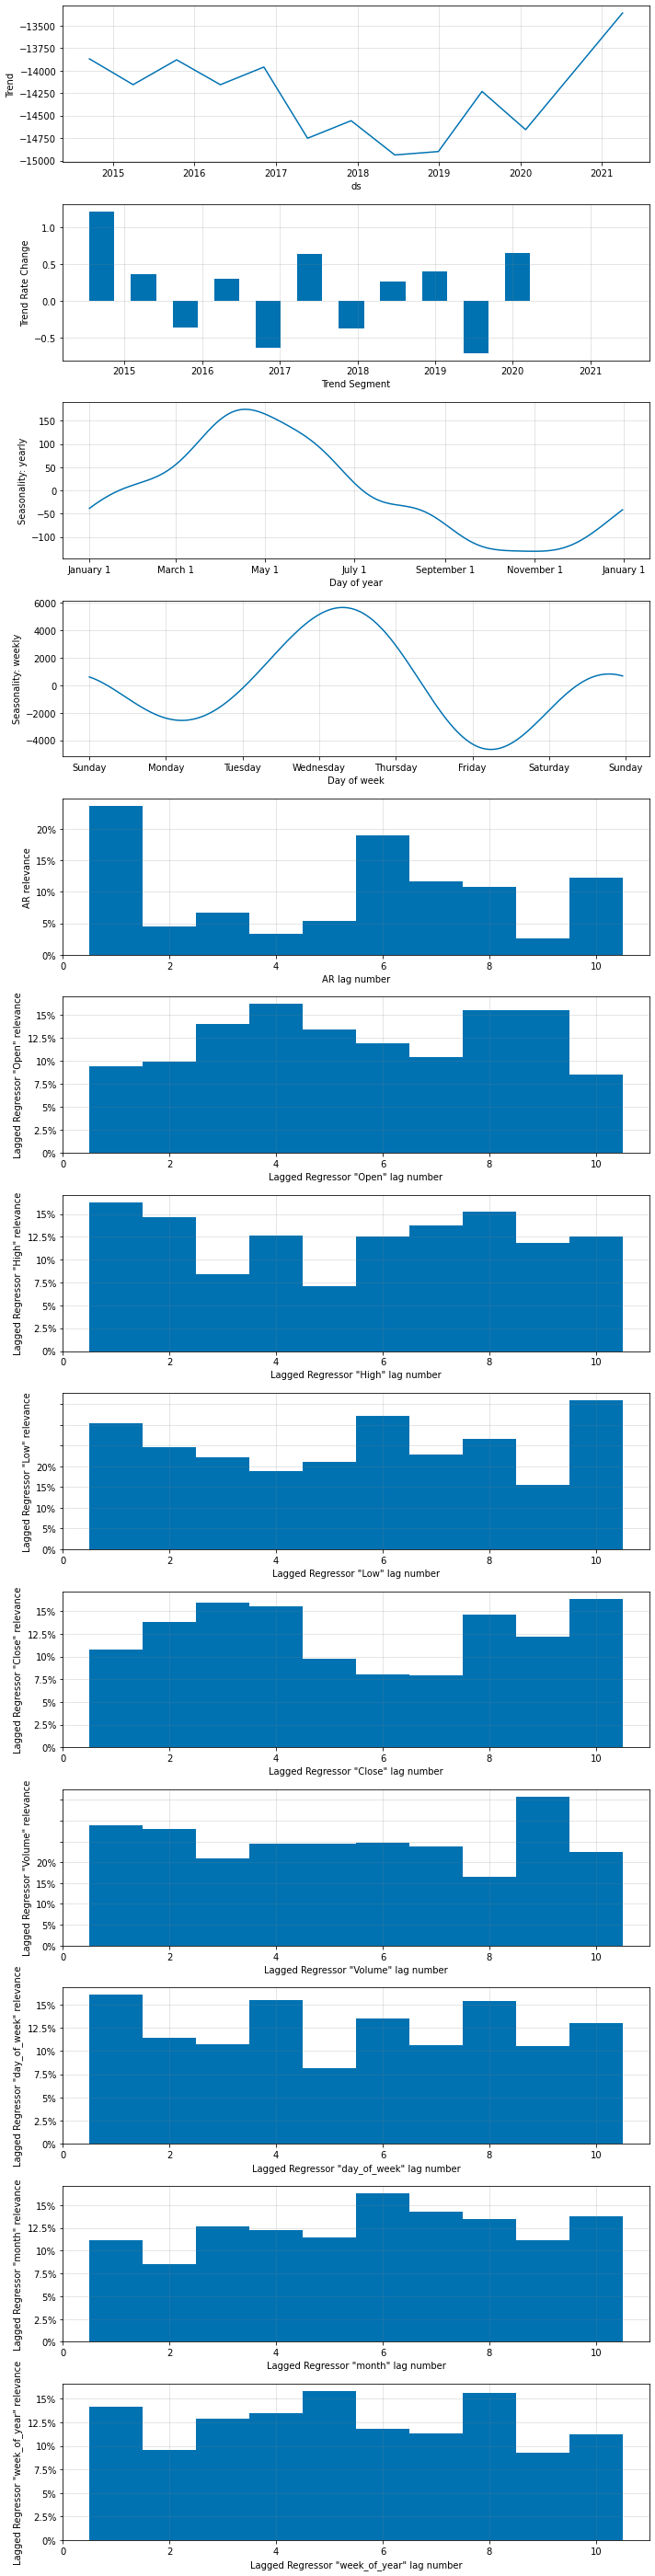

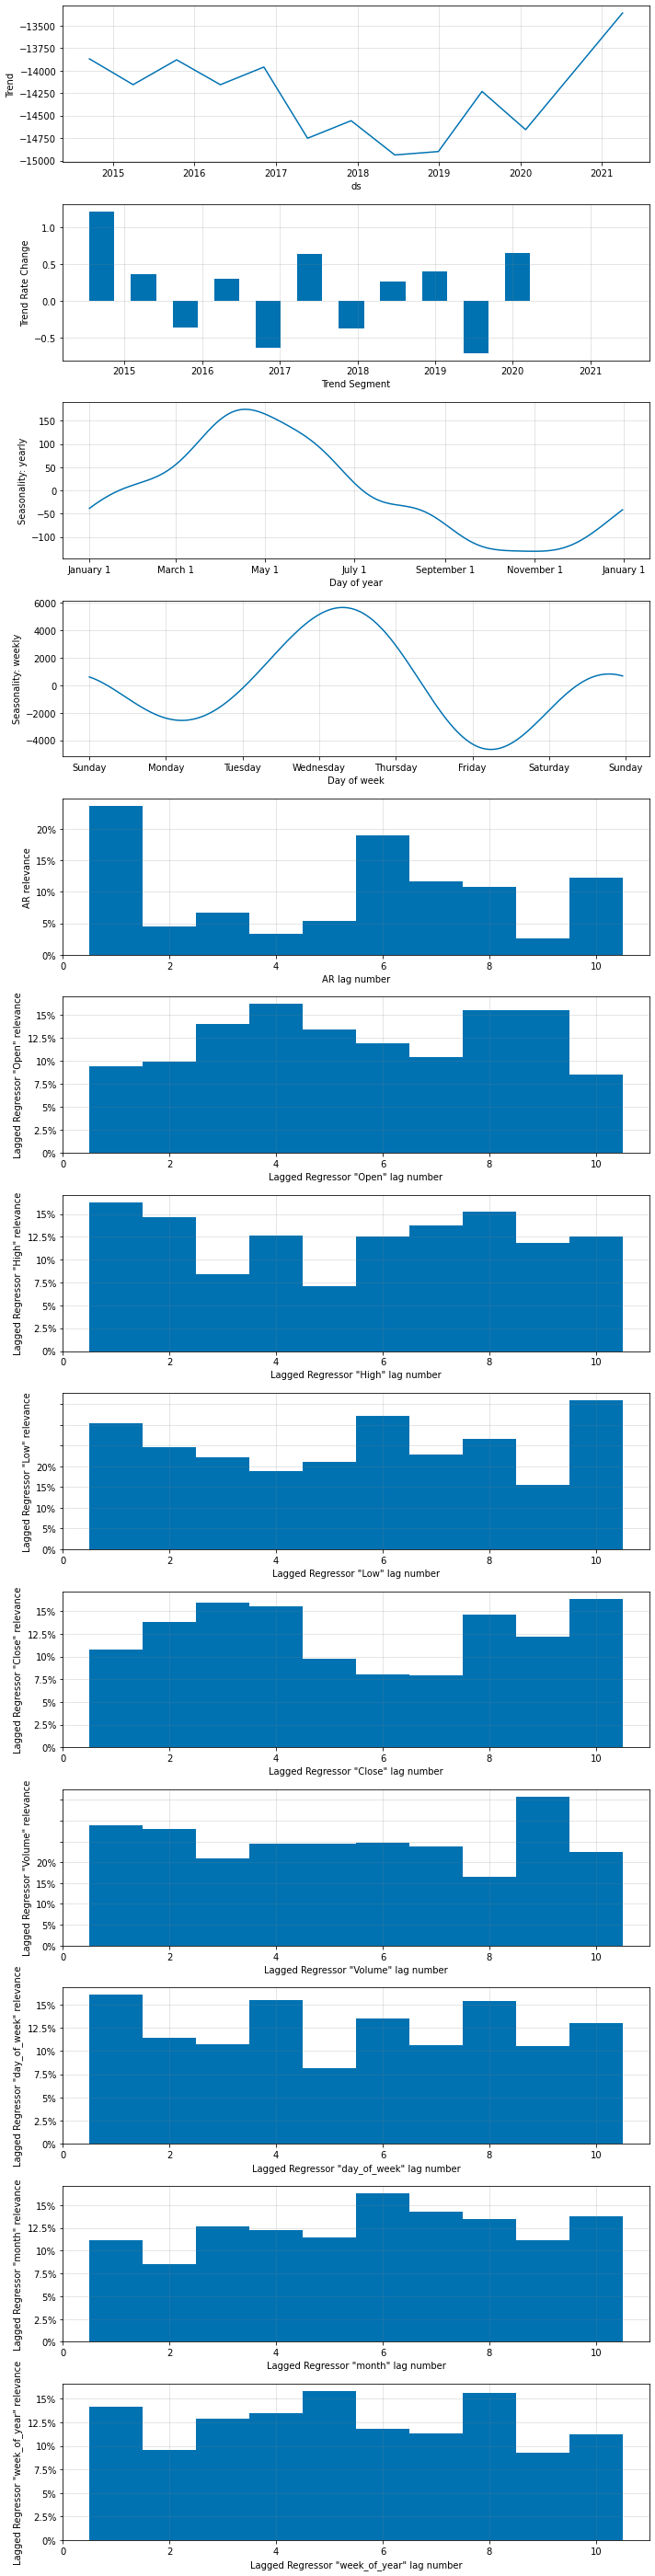

In [62]:
np_model_sparse_nar.plot_parameters()

### Plot forecasts at max lead time

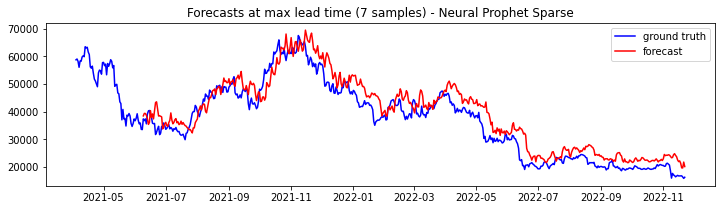

In [63]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet Sparse")
plt.legend(loc='upper right')

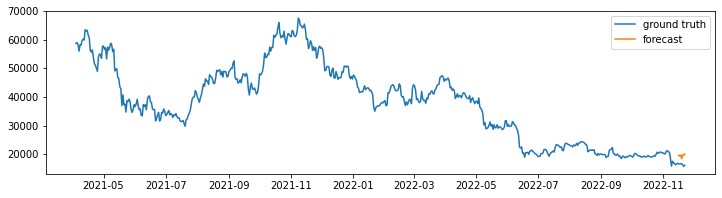

In [64]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

### Append evaluation metrics to `results_df`

In [65]:
results_df = results_df.append(compute_error_statistics(np_sparse_ar_error_metrics, 'neural_prophet_sparse_ar')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,6.968493e+06,2136.756304,1860.883106,0.051495
neural_prophet_sparse_ar_mean_metrics,1.293887e+07,3196.504738,2886.196244,0.092692
neural_prophet_last_sample_only_mean_metrics,2.415699e+07,4513.934436,4028.250462,0.132026
neural_prophet_baseline_mean_metrics,2.636161e+07,4681.659383,4242.120147,0.139498
mean_window_mean_metrics,4.933859e+07,5811.159776,5652.428705,0.158615
prophet_mean_metrics,8.877418e+08,23643.331156,23534.620267,0.951457


# Reflections and Next Steps

So far, the best performing 'model' is the persistence forecasting model. This is, of course, an unsatisfactory result. The best performing experimental model on the exchange rates dataset is the restricted NeuralProphet model that uses only the last observation of lagged regressors as features. Of course, we have only considered a very small number of configurations using NeuralProphet, many more model and hyperparameter configurations are possible. Please refer to the [NeuralProphet documentation](https://neuralprophet.com/html/contents.html) for detailed information. However, to *find* a better configuration may require significant effort, either manual or automated (via a hyperparameter search, for example). In practical forecasting use cases, it may be important to consider the time, resources, and effort that are needed to find a forecasting model that is better than  baseline.

The following notebooks in this series will cover additional models (N-BEATS and DeepAR) as well as rolling cross validation using NeuralProphet. In order to compare the out-of-sample forecasts produced by this notebook to others, the `results_df` DataFrame is saved below. Hopefully we will find a model that performs better than baseline in a continued out-of-sample evaluation experiment!

*Note* The path here should be changed to your local drive folder in order for it to be retrieved in other notebooks. See the beginning of this notebook for context.

In [66]:
output_filename = "/h/sherryxie/forecasting-bootcamp/demos/bitcoin_price_mean_test_metrics.csv"
results_df.to_csv(output_filename)